In [1]:
from math import ceil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import sigmoid, predict, sigmoid_cross_entropy_with_logits, sigmoid_cross_entropy_with_x_w, sigmoid_cross_entropy_truncated, derivative_cost_wrt_params, backtracking_line_search, check_wolfe_II, check_goldstein, line_search, adjust_step_length

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve

In [3]:
csv_path = r"C:\Users\Thanh\Downloads\voice_gender\voice.csv"

In [4]:
df = pd.read_csv(csv_path)

In [5]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [6]:
df['label']=df['label'].replace({'male':1,'female':0})

In [7]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1


In [8]:
x = df.drop("label", axis=1).to_numpy(dtype=np.float)
y = df["label"].values.astype(np.float)

In [9]:
x = (x - np.min(x, axis=0, keepdims=True))/(np.max(x, axis=0, keepdims=True) - np.min(x, axis=0, keepdims=True))
#x = (x-np.mean(x, axis=0, keepdims=True))/np.std(x, axis=0, keepdims=True)

In [10]:
x

array([[9.64185977e-02, 4.73408557e-01, 8.41252523e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.25828039e-01, 5.05074648e-01, 1.16899775e-01, ...,
        2.14438885e-03, 2.14592275e-03, 5.64489929e-02],
       [1.79222164e-01, 6.75535813e-01, 1.02872692e-01, ...,
        3.57398142e-04, 3.57653791e-04, 4.98851565e-02],
       ...,
       [4.84948580e-01, 7.99042208e-01, 6.90336544e-01, ...,
        1.34024303e-01, 1.34120172e-01, 2.08884632e-01],
       [4.92516043e-01, 7.45692037e-01, 6.95311295e-01, ...,
        1.64045747e-01, 1.64163090e-01, 3.33559435e-01],
       [5.95699639e-01, 7.68963896e-01, 6.87590032e-01, ...,
        2.50178699e-02, 2.50357654e-02, 3.75385802e-01]])

In [11]:
x.shape

(3168, 20)

In [12]:
ones = np.ones(shape=[x.shape[0], 1], dtype=np.float)
x = np.append(x, ones, axis=1)
x.shape

(3168, 21)

In [13]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(x, y)

5

In [14]:
for train_index, val_index in skf.split(x, y):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

In [15]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((2535, 21), (633, 21), (2535,), (633,))

In [16]:
#weights = np.random.normal(loc=0, scale=np.sqrt(2/(x.shape[1] + 1)), size=x.shape[1])
weights = np.random.normal(loc=0, scale=np.sqrt(2/(x.shape[1])), size=x.shape[1]-1)
weights = np.append(weights, 0.)

In [17]:
weights

array([-0.23001886,  0.3112653 ,  0.30906287, -0.5266377 , -0.19588805,
        0.5285298 ,  0.22399861, -0.28524896, -0.0762913 ,  0.46876496,
        0.23339827,  0.02523527, -0.18036794,  0.4165704 , -0.01031732,
       -0.30087864,  0.23335313, -0.01126261, -0.00756517, -0.31020268,
        0.        ])

In [18]:
learning_rate = 5

In [19]:
derivative_cost_wrt_params(x=x, w=weights, y=y).shape

(21,)

In [20]:
sigmoid_cross_entropy_with_x_w(x=x, w=weights, y=y)

0.6175874508422827

In [21]:
val_cost_list = {}
val_acc_list = {}

In [22]:
train_cost_list = {}
train_acc_list = {}

In [23]:
wolfe_II_list = {}
goldstein_list = {}

In [24]:
x = x_train
y = y_train
min_val_cost = np.inf
patience = 0
max_weights = weights

val_cost_list["gd"] = []
val_acc_list["gd"] = []

train_cost_list["gd"] = []
train_acc_list["gd"] = []

wolfe_II_list["gd"] = []
goldstein_list["gd"] = []

alpha = 2

for i in range(10000):
    dweights = derivative_cost_wrt_params(x=x, w=weights, y=y)
    #print("dweights: {}".format(dweights))
    #dweights = np.linalg.norm(dweights)
    #if i % 1000 == 0:
    #    learning_rate *= 0.9
    #weights -= learning_rate * dweights
    alpha = backtracking_line_search(x=x, w=weights, y=y, p=-dweights, rho=0.9, alpha=10, c=0.0001)
    #alpha = line_search(x=x, w=weights, y=y, p=-dweights, alpha_max=1, c_1=0.0001, c_2=0.0)
    #alpha = adjust_step_length(x=x, w=weights, y=y, alpha=alpha, p=-dweights, epsilon=1e-3, delta=1e-6)

    wolfe_II_list["gd"].append(check_wolfe_II(x=x, w=weights, y=y, alpha=alpha, p=-dweights, c_2=0.9))
    goldstein_list["gd"].append(check_goldstein(x=x, w=weights, y=y, alpha=alpha, p=-dweights, c=0.25))
    weights -= alpha * dweights
    #print("Alpha: {}".format(alpha))
    #print(weights)
    cost = sigmoid_cross_entropy_with_x_w(x=x, w=weights, y=y)
    val_cost = sigmoid_cross_entropy_with_x_w(x=x_val, w=weights, y=y_val)
    #output = predict(x=x, w=weights, threshold=0.6).astype(np.float)
    #acc = (output == y).sum()/y.shape[0]
    tr_output = predict(x=x, w=weights, threshold=0.6).astype(np.float)
    tr_acc = (tr_output == y).sum()/y.shape[0]
    val_output = predict(x=x_val, w=weights, threshold=0.6).astype(np.float)
    val_acc = (val_output == y_val).sum()/y_val.shape[0]

    val_cost_list["gd"].append(val_cost)
    val_acc_list["gd"].append(val_acc)

    train_cost_list["gd"].append(cost)
    train_acc_list["gd"].append(tr_acc)

    #print(output == y)
    #print(cost, acc)
    print(cost, val_cost, tr_acc, val_acc, patience)
    if val_cost < min_val_cost:
        min_val_cost = val_cost
        patience = 0
        max_weights = weights
    else:
        patience += 1

    #if patience >= 20 and np.allclose(dweights, np.zeros_like(dweights), rtol=1e-3, atol=1e-5):
    if patience >= 20:
        weights = max_weights
        print("Stop at epoch {}, restore weights".format(i))
        break


tr_output = predict(x=x, w=weights, threshold=0.6).astype(np.float)
tr_acc = (tr_output == y).sum()/y.shape[0]
val_output = predict(x=x_val, w=weights, threshold=0.6).astype(np.float)
val_acc = (val_output == y_val).sum()/y_val.shape[0]
print(cost, val_cost, tr_acc, val_acc)
print(dweights, np.linalg.norm(dweights))

0.6051425728475628 0.6622574269050999 0.5191321499013807 0.5055292259083728 0
0.5867668702309089 0.6392926299030125 0.8571992110453649 0.7709320695102686 0
0.5727514615841415 0.6354015764191279 0.5412228796844182 0.5007898894154819 0
0.5725629275925531 0.6322501937554241 0.8528599605522682 0.7693522906793049 0
0.5537401779372632 0.621241944908172 0.5495069033530572 0.4960505529225908 0
0.5495922913490792 0.614522497453753 0.8615384615384616 0.7867298578199052 0
0.5476553772639227 0.6197290252731203 0.5585798816568047 0.4976303317535545 0
0.5379832571928277 0.6071626508807635 0.8611439842209073 0.7898894154818326 1
0.531321976544194 0.6059872879945611 0.5747534516765286 0.5071090047393365 0
0.51784528859957 0.589726336802211 0.8674556213017751 0.8009478672985783 0
0.5080243230107641 0.5835649599042598 0.5909270216962524 0.5086887835703001 0
0.4942638307662804 0.5673893925418515 0.8769230769230769 0.8341232227488151 0
0.48380291701911526 0.5591212924568585 0.6291913214990138 0.5339652448

In [25]:
weights

array([  1.01562606,   1.68680767,  -1.4540336 ,  -2.4939476 ,
         3.71540472,   6.81771005,  -1.28096361,  -1.43302921,
         5.17726754,  -4.13629716,   0.53101923,   1.27088019,
       -22.64398615,   2.50023084,  -0.39600713,   0.36594175,
         0.81170472,   0.26071789,   0.25309604,  -0.54436188,
         3.79733469])

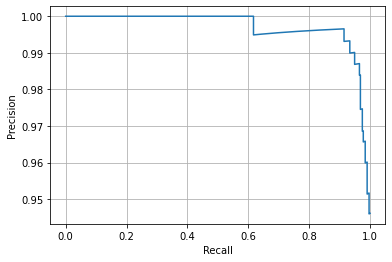

In [26]:
val_prob = predict(x=x_val, w=weights, return_prob=True)
precision, recall, thresholds = precision_recall_curve(y_val, val_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()

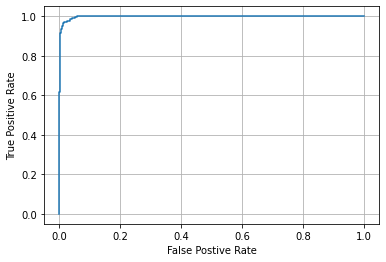

In [27]:
fpr, tpr, thresholds = roc_curve(y_val, val_prob)

plt.plot(fpr, tpr)
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=100, ).fit(x, y)

val_prob = clf.predict_proba(x_val)
val_predict = np.argmax(val_prob, axis=1)
val_acc = (val_predict == y_val).sum()/y_val.shape[0]

val_acc

0.9684044233807267

In [29]:
num_epochs = 1000
batch_size = 64
weights = np.random.normal(loc=0, scale=np.sqrt(2/(x.shape[1])), size=x.shape[1]-1)
weights = np.append(weights, 0.)
alpha = 1e-1
min_val_cost = np.inf
patience = 0
max_weights = weights

val_cost_list["batch"] = []
val_acc_list["batch"] = []

train_cost_list["batch"] = []
train_acc_list["batch"] = []

wolfe_II_list["batch"] = []
goldstein_list["batch"] = []

alpha = 1e-1

for i in range(num_epochs):
    index = np.arange(x_train.shape[0])
    np.random.shuffle(index)
    for j in range(ceil(x_train.shape[0]/64)):
        index_batch = index[j * batch_size: j * batch_size + batch_size]
        x_batch = x_train[index_batch]
        y_batch = y_train[index_batch]
        #x_batch = x_train[j * batch_size: j * batch_size + batch_size]
        #y_batch = y_train[j * batch_size: j * batch_size + batch_size]
        #print(x_batch.shape, y_batch.shape)

        dweights = derivative_cost_wrt_params(x=x_batch, w=weights, y=y_batch)
        alpha = backtracking_line_search(x=x_batch, w=weights, y=y_batch, p=-dweights, rho=0.9, alpha=1e-1, c=0.0001)
        #alpha = line_search(x=x_batch, w=weights, y=y, p=-dweights, alpha_max=1e-1, c_1=0.0001, c_2=0.9)
        #alpha = adjust_step_length(x=x_batch, w=weights, y=y_batch, alpha=alpha, p=-dweights, epsilon=1e-3, delta=1e-6)

        wolfe_II_list["batch"].append(check_wolfe_II(x=x_batch, w=weights, y=y_batch, alpha=alpha, p=-dweights, c_2=0.9))
        goldstein_list["batch"].append(check_goldstein(x=x_batch, w=weights, y=y_batch, alpha=alpha, p=-dweights, c=0.25))
        #print(alpha)
        weights -= alpha * dweights

        cost = sigmoid_cross_entropy_with_x_w(x=x_batch, w=weights, y=y_batch)
        
        tr_output = predict(x=x_batch, w=weights, threshold=0.6).astype(np.float)
        tr_acc = (tr_output == y_batch).sum()/y_batch.shape[0]
        #print(i, j, cost, tr_acc)

    cost = sigmoid_cross_entropy_with_x_w(x=x_train, w=weights, y=y_train)
    tr_output = predict(x=x_train, w=weights, threshold=0.6).astype(np.float)
    tr_acc = (tr_output == y_train).sum()/y_train.shape[0]
    val_cost = sigmoid_cross_entropy_with_x_w(x=x_val, w=weights, y=y_val)
    val_output = predict(x=x_val, w=weights, threshold=0.6).astype(np.float)
    val_acc = (val_output == y_val).sum()/y_val.shape[0]

    val_cost_list["batch"].append(val_cost)
    val_acc_list["batch"].append(val_acc)

    train_cost_list["batch"].append(cost)
    train_acc_list["batch"].append(tr_acc)

    print(i, cost, tr_acc, val_cost, val_acc)
    #if val_cost < min_val_cost:
    #    min_val_cost = val_cost
    #    patience = 0
    #    max_weights = weights
    #else:
    #    patience += 1
#
    ##if patience >= 20 and np.allclose(dweights, np.zeros_like(dweights), rtol=1e-3, atol=1e-5):
    #if patience >= 100:
    #    weights = max_weights
    #    print("Stop at epoch {}, restore weights".format(i))
    #    break

0 0.5992024500675684 0.5952662721893491 0.6416115871115824 0.5402843601895735
1 0.5581138514208349 0.6414201183431952 0.6137828525140506 0.5892575039494471
2 0.5283901421588239 0.6670611439842209 0.5923768549711631 0.608214849921011
3 0.5046755528570536 0.7065088757396449 0.5742368502576247 0.617693522906793
4 0.4856703170750816 0.729388560157791 0.5588476518928587 0.631911532385466
5 0.4696002001877446 0.729388560157791 0.5447212663256755 0.6303317535545023
6 0.45546798283642986 0.7380670611439842 0.5319533119242075 0.6619273301737757
7 0.443009778919837 0.7435897435897436 0.5200660157339733 0.6714060031595577
8 0.43263703474083876 0.7408284023668639 0.5096238401375248 0.660347551342812
9 0.42193929151396153 0.7869822485207101 0.499216097034528 0.7519747235387045
10 0.4118689492386935 0.7822485207100591 0.4884934379086834 0.7488151658767772
11 0.40290173207943947 0.7861932938856016 0.47887657708767367 0.7488151658767772
12 0.39508821695371654 0.8165680473372781 0.4705328594809107 0.79

In [30]:
weights

array([  0.87764694,   2.00493329,  -1.71261   ,  -2.86994898,
         3.93491376,   6.2152424 ,  -1.13636196,  -1.35216815,
         5.37350139,  -4.27151761,   0.57943705,   1.84629939,
       -22.06433609,   2.29316181,  -0.4419066 ,   0.42492335,
         0.72934436,   0.12901322,   0.35671254,  -0.53240664,
         3.50660731])

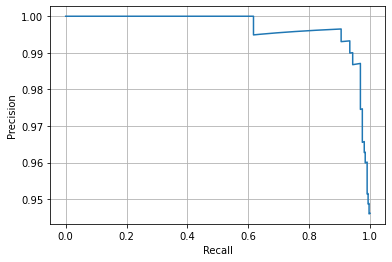

In [31]:
val_prob = predict(x=x_val, w=weights, return_prob=True)
precision, recall, thresholds = precision_recall_curve(y_val, val_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()

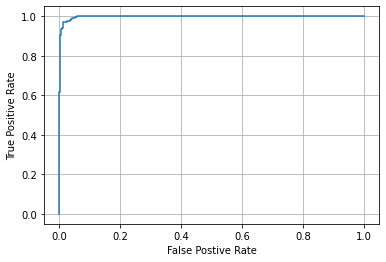

In [32]:
fpr, tpr, thresholds = roc_curve(y_val, val_prob)

plt.plot(fpr, tpr)
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

In [33]:
num_epochs = 500
batch_size = 1
weights = np.random.normal(loc=0, scale=np.sqrt(2/(x.shape[1])), size=x.shape[1]-1)
weights = np.append(weights, 0.)
alpha = 1e-1
min_val_cost = np.inf
patience = 0
max_weights = weights

val_cost_list["sgd"] = []
val_acc_list["sgd"] = []

train_cost_list["sgd"] = []
train_acc_list["sgd"] = []

wolfe_II_list["sgd"] = []
goldstein_list["sgd"] = []

alpha = 1e-1

for i in range(num_epochs):
    index = np.arange(x_train.shape[0])
    np.random.shuffle(index)
    for j in range(ceil(x_train.shape[0]/64)):
        index_batch = index[j * batch_size: j * batch_size + batch_size]
        x_batch = x_train[index_batch]
        y_batch = y_train[index_batch]
        #x_batch = x_train[j * batch_size: j * batch_size + batch_size]
        #y_batch = y_train[j * batch_size: j * batch_size + batch_size]
        #print(x_batch.shape, y_batch.shape)

        dweights = derivative_cost_wrt_params(x=x_batch, w=weights, y=y_batch)
        alpha = backtracking_line_search(x=x_batch, w=weights, y=y_batch, p=-dweights, rho=0.9, alpha=1e-1, c=0.0001)
        #alpha = line_search(x=x_batch, w=weights, y=y, p=-dweights, alpha_max=1e-1, c_1=0.0001, c_2=0.9)
        #alpha = adjust_step_length(x=x_batch, w=weights, y=y_batch, alpha=alpha, p=-dweights, epsilon=1e-3, delta=1e-6)
        #print(alpha)

        wolfe_II_list["sgd"].append(check_wolfe_II(x=x_batch, w=weights, y=y_batch, alpha=alpha, p=-dweights, c_2=0.9))
        goldstein_list["sgd"].append(check_goldstein(x=x_batch, w=weights, y=y_batch, alpha=alpha, p=-dweights, c=0.25))
        weights -= alpha * dweights

        cost = sigmoid_cross_entropy_with_x_w(x=x_batch, w=weights, y=y_batch)
        
        tr_output = predict(x=x_batch, w=weights, threshold=0.6).astype(np.float)
        tr_acc = (tr_output == y_batch).sum()/y_batch.shape[0]
        #print(i, j, cost, tr_acc)

    cost = sigmoid_cross_entropy_with_x_w(x=x_train, w=weights, y=y_train)
    tr_output = predict(x=x_train, w=weights, threshold=0.6).astype(np.float)
    tr_acc = (tr_output == y_train).sum()/y_train.shape[0]
    val_cost = sigmoid_cross_entropy_with_x_w(x=x_val, w=weights, y=y_val)
    val_output = predict(x=x_val, w=weights, threshold=0.6).astype(np.float)
    val_acc = (val_output == y_val).sum()/y_val.shape[0]

    val_cost_list["sgd"].append(val_cost)
    val_acc_list["sgd"].append(val_acc)

    train_cost_list["sgd"].append(cost)
    train_acc_list["sgd"].append(tr_acc)


    print(i, cost, tr_acc, val_cost, val_acc)
    #if val_cost < min_val_cost:
    #    min_val_cost = val_cost
    #    patience = 0
    #    max_weights = weights
    #else:
    #    patience += 1
#
    ##if patience >= 20 and np.allclose(dweights, np.zeros_like(dweights), rtol=1e-3, atol=1e-5):
    #if patience >= 100:
    #    weights = max_weights
    #    print("Stop at epoch {}, restore weights".format(i))
    #    break

0 0.6866399396275457 0.49980276134122287 0.6897618634438888 0.5007898894154819
1 0.5741286609045245 0.5207100591715976 0.5957734141501111 0.5118483412322274
2 0.5315795073899197 0.6153846153846154 0.5718012609870464 0.5513428120063191
3 0.4930619846737926 0.7076923076923077 0.5438821560245095 0.6429699842022117
4 0.491358244073543 0.8812623274161736 0.5513163789337024 0.8246445497630331
5 0.5093696959462078 0.6145956607495069 0.5811343488800139 0.5481832543443917
6 0.49829124499771116 0.8698224852071006 0.5608933299435926 0.8341232227488151
7 0.44119982359208115 0.8654832347140039 0.5060347792287511 0.7993680884676145
8 0.5184290313487679 0.5897435897435898 0.5879931250955752 0.5292259083728278
9 0.4451266738961896 0.6875739644970414 0.5104195713262735 0.5813586097946287
10 0.41063917282342793 0.8863905325443787 0.4744612122940066 0.8404423380726699
11 0.4022081723301093 0.745956607495069 0.4700101826112666 0.6666666666666666
12 0.386858716552055 0.8560157790927022 0.45693960453559757 

In [34]:
weights, dweights

(array([  0.57856626,   1.43017038,  -0.34938473,  -2.1421617 ,
          3.51542413,   6.08211552,  -0.71694379,  -0.53107672,
          4.15835444,  -2.66555276,   0.63402365,   1.22676093,
        -19.17519028,   1.51528512,  -0.85722503,   0.54097156,
          0.3729642 ,   0.58637313,  -0.07858583,  -0.7959166 ,
          2.28565538]),
 array([0.10826724, 0.10505797, 0.13215342, 0.07388931, 0.14334282,
        0.08502854, 0.01639465, 0.00240772, 0.17506487, 0.16237115,
        0.13549888, 0.10826724, 0.11585328, 0.03700542, 0.18905938,
        0.05720781, 0.00787041, 0.06911662, 0.06902828, 0.01798616,
        0.19261784]))

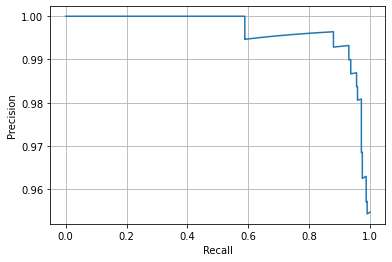

In [35]:
val_prob = predict(x=x_val, w=weights, return_prob=True)
precision, recall, thresholds = precision_recall_curve(y_val, val_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()

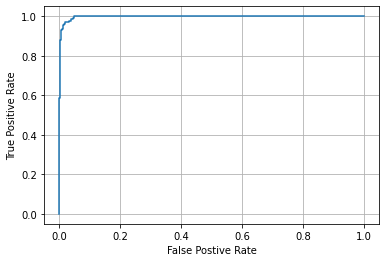

In [36]:
fpr, tpr, thresholds = roc_curve(y_val, val_prob)

plt.plot(fpr, tpr)
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

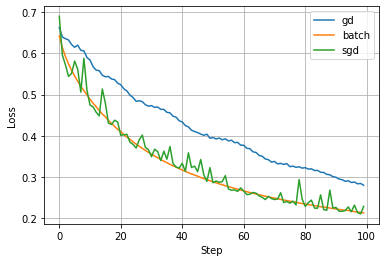

In [37]:
for method in val_cost_list:
    #plt.plot(np.arange(len(val_cost_list[method])), val_cost_list[method], label=method)
    plt.plot(np.arange(100), val_cost_list[method][:100], label=method)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()

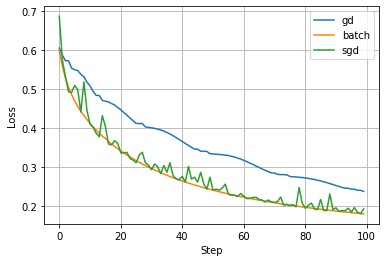

In [38]:
for method in train_cost_list:
    #plt.plot(np.arange(len(val_cost_list[method])), val_cost_list[method], label=method)
    plt.plot(np.arange(100), train_cost_list[method][:100], label=method)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()

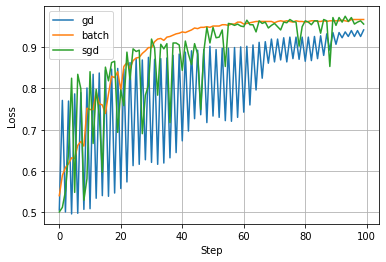

In [39]:
for method in val_acc_list:
    #plt.plot(np.arange(len(val_cost_list[method])), val_cost_list[method], label=method)
    plt.plot(np.arange(100), val_acc_list[method][:100], label=method)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()

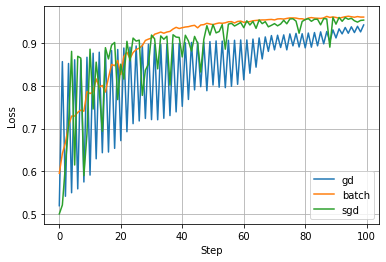

In [40]:
for method in train_acc_list:
    #plt.plot(np.arange(len(val_cost_list[method])), val_cost_list[method], label=method)
    plt.plot(np.arange(100), train_acc_list[method][:100], label=method)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()

In [41]:
wolfe_II_list

{'gd': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  

In [42]:
goldstein_list

{'gd': [False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  Fa